In [1]:
import pandas as pd

df = pd.read_csv("baza_faq.csv", encoding="utf-8")

train_df = df[df["split"]=="train"].reset_index(drop=True)
dev_df   = df[df["split"]=="dev"].reset_index(drop=True)
test_df  = df[df["split"]=="test"].reset_index(drop=True)

print("Veličine:", len(train_df), len(dev_df), len(test_df))
print("Intents:", df["intent"].nunique())


Veličine: 154 23 26
Intents: 11


In [2]:
import re
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE


'cpu'

In [3]:
def tokenize(text: str):
    text = text.lower().strip()
    return re.findall(r"[a-zA-ZčćšđžČĆŠĐŽ0-9]+", text)

def build_vocab(texts, min_freq=1, max_size=30000):
    counter = Counter()
    for t in texts:
        counter.update(tokenize(t))
    stoi = {"<pad>":0, "<unk>":1}
    itos = ["<pad>", "<unk>"]
    for tok, freq in counter.most_common():
        if freq < min_freq:
            continue
        if tok in stoi:
            continue
        stoi[tok] = len(itos)
        itos.append(tok)
        if len(itos) >= max_size:
            break
    return stoi, itos

def encode(text, stoi):
    return [stoi.get(tok, stoi["<unk>"]) for tok in tokenize(text)]

intents = sorted(df["intent"].unique().tolist())
intent2id = {k:i for i,k in enumerate(intents)}
id2intent = {i:k for k,i in intent2id.items()}

stoi, itos = build_vocab(train_df["question"].tolist(), min_freq=1)
print("Vocab size:", len(itos), "| Num intents:", len(intents))


Vocab size: 488 | Num intents: 11


In [4]:
class IntentDataset(Dataset):
    def __init__(self, df, stoi, intent2id):
        self.q = df["question"].tolist()
        self.y = [intent2id[i] for i in df["intent"].tolist()]
        self.stoi = stoi

    def __len__(self):
        return len(self.q)

    def __getitem__(self, idx):
        x = torch.tensor(encode(self.q[idx], self.stoi), dtype=torch.long)
        y = torch.tensor(self.y[idx], dtype=torch.long)
        return x, y

def collate_batch(batch):
    xs, ys = zip(*batch)
    lengths = torch.tensor([len(x) for x in xs], dtype=torch.long)
    max_len = int(lengths.max().item())
    padded = torch.zeros(len(xs), max_len, dtype=torch.long)  # pad id = 0
    for i, x in enumerate(xs):
        padded[i, :len(x)] = x
    return padded, torch.stack(ys), lengths

train_loader = DataLoader(IntentDataset(train_df, stoi, intent2id),
                          batch_size=16, shuffle=True, collate_fn=collate_batch)

dev_loader   = DataLoader(IntentDataset(dev_df, stoi, intent2id),
                          batch_size=32, shuffle=False, collate_fn=collate_batch)

test_loader  = DataLoader(IntentDataset(test_df, stoi, intent2id),
                          batch_size=32, shuffle=False, collate_fn=collate_batch)


In [5]:
class BiLSTMIntent(nn.Module):
    def __init__(self, vocab_size, num_classes, emb_dim=128, hidden_dim=128, dropout=0.3):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x, lengths):
        emb = self.emb(x)
        packed = nn.utils.rnn.pack_padded_sequence(
            emb, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        _, (h, _) = self.lstm(packed)
        h_fwd = h[-2]
        h_bwd = h[-1]
        h_cat = torch.cat([h_fwd, h_bwd], dim=1)
        return self.fc(self.drop(h_cat))

model = BiLSTMIntent(vocab_size=len(itos), num_classes=len(intents)).to(DEVICE)
model


BiLSTMIntent(
  (emb): Embedding(488, 128, padding_idx=0)
  (lstm): LSTM(128, 128, batch_first=True, bidirectional=True)
  (drop): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=11, bias=True)
)

In [6]:
train_counts = train_df["intent"].value_counts()
weights = torch.zeros(len(intents), dtype=torch.float)
for intent, idx in intent2id.items():
    weights[idx] = 1.0 / max(1, train_counts.get(intent, 0))
weights = (weights / weights.sum()) * len(intents)
weights = weights.to(DEVICE)

loss_fn = nn.CrossEntropyLoss(weight=weights)
opt = torch.optim.Adam(model.parameters(), lr=3e-3)

In [7]:
@torch.no_grad()
def evaluate(loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    for x, y, lengths in loader:
        x, y, lengths = x.to(DEVICE), y.to(DEVICE), lengths.to(DEVICE)
        logits = model(x, lengths)
        loss = loss_fn(logits, y)
        total_loss += loss.item() * y.size(0)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return total_loss / total, correct / total

def train_one_epoch():
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for x, y, lengths in train_loader:
        x, y, lengths = x.to(DEVICE), y.to(DEVICE), lengths.to(DEVICE)
        opt.zero_grad()
        logits = model(x, lengths)
        loss = loss_fn(logits, y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        total_loss += loss.item() * y.size(0)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    return total_loss / total, correct / total


In [8]:
best_dev_acc = -1.0
best_state = None

EPOCHS = 20

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch()
    dv_loss, dv_acc = evaluate(dev_loader)

    print(f"[{epoch:02d}] train loss={tr_loss:.4f} acc={tr_acc:.3f} | dev loss={dv_loss:.4f} acc={dv_acc:.3f}")

    if dv_acc > best_dev_acc:
        best_dev_acc = dv_acc
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

# vrati najbolji model po dev accuracy
model.load_state_dict(best_state)
torch.save(best_state, "intent_bilstm.pt")

ts_loss, ts_acc = evaluate(test_loader)
print(f"\nBEST dev acc={best_dev_acc:.3f}")
print(f"TEST loss={ts_loss:.4f} acc={ts_acc:.3f}")


[01] train loss=2.3568 acc=0.188 | dev loss=2.2850 acc=0.217
[02] train loss=1.6643 acc=0.721 | dev loss=2.1356 acc=0.391
[03] train loss=1.0211 acc=0.818 | dev loss=1.8811 acc=0.391
[04] train loss=0.4288 acc=0.922 | dev loss=1.8723 acc=0.435
[05] train loss=0.1181 acc=0.974 | dev loss=2.0988 acc=0.435
[06] train loss=0.0455 acc=0.994 | dev loss=2.2876 acc=0.478
[07] train loss=0.0117 acc=1.000 | dev loss=2.3402 acc=0.478
[08] train loss=0.0066 acc=1.000 | dev loss=2.3610 acc=0.478
[09] train loss=0.0044 acc=1.000 | dev loss=2.3453 acc=0.478
[10] train loss=0.0037 acc=1.000 | dev loss=2.3831 acc=0.478
[11] train loss=0.0029 acc=1.000 | dev loss=2.4219 acc=0.478
[12] train loss=0.0020 acc=1.000 | dev loss=2.4426 acc=0.478
[13] train loss=0.0018 acc=1.000 | dev loss=2.4565 acc=0.478
[14] train loss=0.0019 acc=1.000 | dev loss=2.4810 acc=0.478
[15] train loss=0.0015 acc=1.000 | dev loss=2.5031 acc=0.478
[16] train loss=0.0013 acc=1.000 | dev loss=2.5236 acc=0.478
[17] train loss=0.0014 a

In [9]:
import os
os.makedirs("models", exist_ok=True)

torch.save(
    {
        "state_dict": model.state_dict(),
        "stoi": stoi,
        "itos": itos,
        "intent2id": intent2id,
        "id2intent": id2intent,
    },
    "models/intent_bilstm.pt"
)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Radim retrieval nad TRAIN bazom (da izbjegnem "varanje" s testom)
retrieval_df = train_df.copy()

# Radim TF-IDF po intentu: za svaki intent svoj vektorizator i svoju matricu
intent_index = {}

for intent in retrieval_df["intent"].unique():
    sub = retrieval_df[retrieval_df["intent"] == intent].reset_index(drop=True)
    vect = TfidfVectorizer(ngram_range=(1,2), min_df=1)
    X = vect.fit_transform(sub["question"].tolist())
    intent_index[intent] = {
        "df": sub,
        "vectorizer": vect,
        "X": X
    }



Built retrieval index for intents: 11


In [10]:
import torch

@torch.no_grad()
def predict_intent(question: str):
    model.eval()
    ids = encode(question, stoi)
    if len(ids) == 0:
        return None
    x = torch.tensor(ids, dtype=torch.long).unsqueeze(0)
    lengths = torch.tensor([x.size(1)], dtype=torch.long)
    x, lengths = x.to(DEVICE), lengths.to(DEVICE)
    logits = model(x, lengths)
    pred_id = int(logits.argmax(1).item())
    return id2intent[pred_id]

def retrieve_answer_within_intent(question: str, intent: str):
    """Vraća (answer, best_question, score, answer_id) iz train baze unutar intenta."""
    idx = intent_index.get(intent)
    if idx is None:
        return None, None, 0.0, None

    vect = idx["vectorizer"]
    X = idx["X"]
    sub = idx["df"]

    q_vec = vect.transform([question])
    sims = cosine_similarity(q_vec, X).ravel()
    best_i = int(np.argmax(sims))
    best_score = float(sims[best_i])

    best_row = sub.iloc[best_i]
    return best_row["answer"], best_row["question"], best_score, best_row["answer_id"]

def chat(q: str, min_sim=0.20):
    """
    - predvidi intent BiLSTM-om
    - retrieval unutar intenta TF-IDF cosine
    - ako je sličnost preniska, vrati fallback
    """
    intent = predict_intent(q)
    if intent is None:
        return {"intent": None, "answer": "Nisam siguran da razumijem pitanje. Možeš li ga malo preformulirati?"}

    answer, matched_q, score, answer_id = retrieve_answer_within_intent(q, intent)

    if score < min_sim:
        # fallback: ponudi što je model mislio + traži pojašnjenje
        return {
            "intent": intent,
            "answer": "Nisam siguran da imam točan odgovor. Možeš li navesti više detalja (npr. koji studij/semestar/rok)?",
            "matched_question": matched_q,
            "similarity": score,
            "answer_id": answer_id
        }

    return {
        "intent": intent,
        "answer": answer,
        "matched_question": matched_q,
        "similarity": score,
        "answer_id": answer_id
    }


In [11]:
chat("Koje je radno vrijeme referade?")


{'intent': 'referada',
 'answer': 'Radno vrijeme za studente je ponedjeljak–petak 7:30–14:30.',
 'matched_question': 'Radno vrijeme referade?',
 'similarity': 0.7432511013213126,
 'answer_id': 'A011'}

In [15]:
chat("Kako se prijavljujem na Erasmus?")


{'intent': 'anketa',
 'answer': 'Navodi se da studenti mogu ispuniti anketu prijavom u Studomat, u bilo koje vrijeme i s bilo kojeg mjesta.',
 'matched_question': 'Kako se ispunjava interna anketa Fakulteta?',
 'similarity': 0.5001958223083195,
 'answer_id': 'A088'}

In [13]:
chat("Tko je dekan?")

{'intent': 'studentski_zbor',
 'answer': 'Studentski pravobranitelj je Zvonimir Šego, a e-mail je pravobranitelj@mathos.hr',
 'matched_question': 'Tko je studentski pravobranitelj i kako ga kontaktirati?',
 'similarity': 0.4309681103630515,
 'answer_id': 'A096'}

In [15]:
chat("Tko je dekan fakulteta?")

{'intent': 'studentski_zbor',
 'answer': 'Studentski pravobranitelj je Zvonimir Šego, a e-mail je pravobranitelj@mathos.hr',
 'matched_question': 'Tko je studentski pravobranitelj i kako ga kontaktirati?',
 'similarity': 0.35384299570480704,
 'answer_id': 'A096'}

In [16]:
chat("Gdje mogu dobiti potvrdu o statusu studenta?")


{'intent': 'referada',
 'answer': 'Potvrde o statusu studenta izdaje studentska referada (Ured za studente i studije).',
 'matched_question': 'Gdje mogu dobiti potvrdu o studiranju?',
 'similarity': 0.6608818863697014,
 'answer_id': 'A154'}

In [13]:
chat("Kako se upisati na fakultet?")

{'intent': 'anketa',
 'answer': 'Navodi se da studenti mogu ispuniti anketu prijavom u Studomat, u bilo koje vrijeme i s bilo kojeg mjesta.',
 'matched_question': 'Kako se ispunjava interna anketa Fakulteta?',
 'similarity': 0.5001958223083195,
 'answer_id': 'A088'}

In [20]:
chat("Koje godine je osnovan fakultet?")

{'intent': 'povijest',
 'answer': 'Odjel za matematiku osnovan je 1. listopada 1999. godine.',
 'matched_question': 'Kada je službeno osnovan Odjel za matematiku koji je prethodio današnjem Fakultetu?',
 'similarity': 0.21195148730616276,
 'answer_id': 'A001'}

In [21]:
chat("Kako prijaviti ispit na studomatu?")

{'intent': 'erasmus',
 'answer': 'Nа stranici mobilnosti naveden je akademski Erasmus koordinator Ivan Papić s kontaktom ipapic@mathos.hr.',
 'matched_question': 'Tko je akademski Erasmus koordinator i kako ga kontaktirati?',
 'similarity': 0.21902994586518537,
 'answer_id': 'A104'}

In [16]:
chat("Raspored?")

{'intent': 'nastava',
 'answer': 'Raspored nastave, promjene termina i informacije o kolegijima objavljuju se na službenim stranicama fakulteta i/ili putem sustava za e-učenje i obavijesti nastavnika.',
 'matched_question': 'Gdje mogu vidjeti raspored predavanja?',
 'similarity': 0.3026286234913486,
 'answer_id': 'A160'}

U idućim čelijama radim evaluaciju modela.

In [17]:
import numpy as np
import torch

@torch.no_grad()
def predict_dataset(loader):
    model.eval()
    y_true = []
    y_pred = []

    for x, y, lengths in loader:
        x, y, lengths = x.to(DEVICE), y.to(DEVICE), lengths.to(DEVICE)
        logits = model(x, lengths)
        pred = logits.argmax(1)

        y_true.extend(y.cpu().numpy().tolist())
        y_pred.extend(pred.cpu().numpy().tolist())

    return np.array(y_true), np.array(y_pred)


In [18]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

y_true_dev, y_pred_dev = predict_dataset(dev_loader)
y_true_test, y_pred_test = predict_dataset(test_loader)

print("DEV accuracy:", accuracy_score(y_true_dev, y_pred_dev))
print("DEV macro-F1:", f1_score(y_true_dev, y_pred_dev, average="macro"))

print("\nTEST accuracy:", accuracy_score(y_true_test, y_pred_test))
print("TEST macro-F1:", f1_score(y_true_test, y_pred_test, average="macro"))


DEV accuracy: 0.43478260869565216
DEV macro-F1: 0.31746031746031744

TEST accuracy: 0.34615384615384615
TEST macro-F1: 0.3116883116883117


In [20]:
labels = list(range(len(id2intent)))
target_names = [id2intent[i] for i in labels]

print("DEV report:\n")
print(classification_report(
    y_true_dev,
    y_pred_dev,
    labels=labels,
    target_names=target_names,
    zero_division=0
))

print("\nTEST report:\n")
print(classification_report(
    y_true_test,
    y_pred_test,
    labels=labels,
    target_names=target_names,
    zero_division=0
))


DEV report:

                 precision    recall  f1-score   support

         anketa       0.17      1.00      0.29         2
  cijelozivotno       1.00      0.50      0.67         2
        erasmus       1.00      0.50      0.67         2
             it       0.00      0.00      0.00         2
      knjiznica       0.00      0.00      0.00         2
     mathos_cup       0.50      1.00      0.67         2
        nastava       0.00      0.00      0.00         3
       povijest       0.00      0.00      0.00         1
       referada       0.00      0.00      0.00         0
studentski_zbor       0.00      0.00      0.00         2
          upisi       1.00      0.80      0.89         5

       accuracy                           0.43        23
      macro avg       0.33      0.35      0.29        23
   weighted avg       0.45      0.43      0.39        23


TEST report:

                 precision    recall  f1-score   support

         anketa       0.10      0.50      0.17         2

In [21]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true_test, y_pred_test)
cm


array([[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3]])

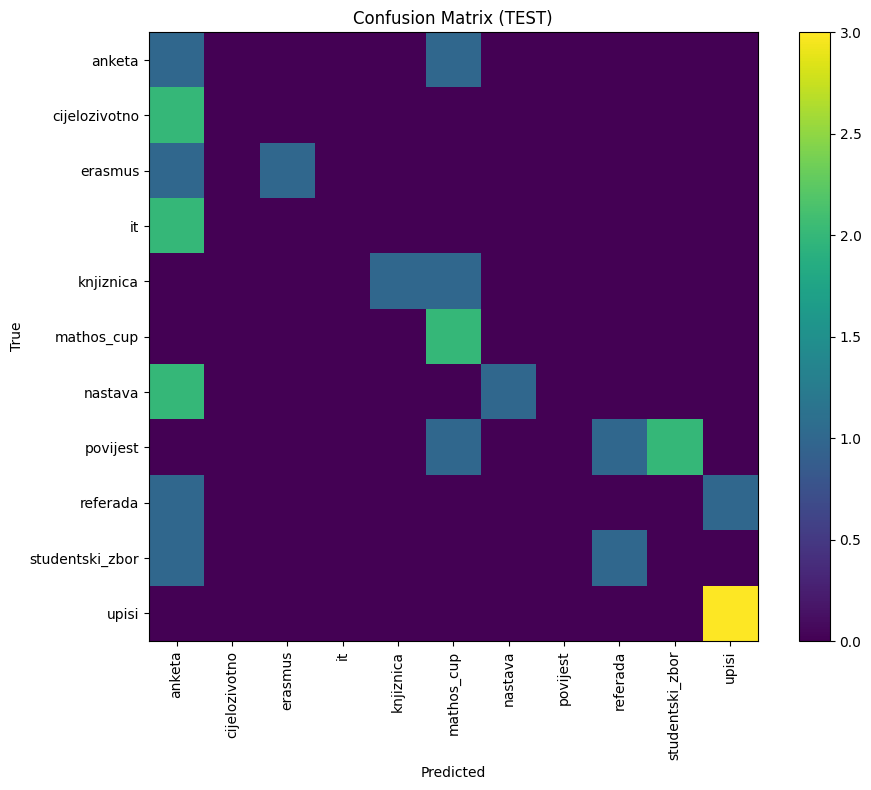

In [22]:
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_test, y_pred_test)
labels = [id2intent[i] for i in range(len(id2intent))]

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (TEST)")
plt.colorbar()
plt.xticks(range(len(labels)), labels, rotation=90)
plt.yticks(range(len(labels)), labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [23]:
test_questions = test_df["question"].tolist()
true_intents = [intent2id[x] for x in test_df["intent"].tolist()]

rows = []
for q, yt, yp in zip(test_questions, y_true_test, y_pred_test):
    if yt != yp:
        rows.append({
            "question": q,
            "true_intent": id2intent[int(yt)],
            "pred_intent": id2intent[int(yp)],
        })

errors_df = pd.DataFrame(rows)
errors_df.head(20)


,question,true_intent,pred_intent
0,Gdje je danas smješten Fakultet primijenjene m...,povijest,referada
1,Kako se pridružujem Teams “timovima” pojedinih...,it,anketa
2,Jesu li podaci za prijavu u anketu isti kao za...,it,anketa
3,Postoji li poticaj/nagrada za ispunjavanje int...,anketa,mathos_cup
4,Tko zaprima prijave i što se s njima radi?,studentski_zbor,referada
5,Što ako žrtva ne želi da se prijava proslijedi?,studentski_zbor,anketa
6,Što je Learning Agreement i što obuhvaća?,erasmus,anketa
7,Trebam li jako matematičko predznanje za “Prim...,cijelozivotno,anketa
8,Kako se prijavljujem za “Primijenjenu statisti...,cijelozivotno,anketa
9,Koja su osnovna pravila ponašanja u čitaonici ...,knjiznica,mathos_cup


In [25]:
chat("Kada radi referada?")

{'intent': 'referada',
 'answer': 'Radno vrijeme za studente je ponedjeljak–petak 7:30–14:30.',
 'matched_question': 'Kad referada radi sa studentima?',
 'similarity': 0.3218260258826585,
 'answer_id': 'A011'}